In [ ]:
from google.colab import drive
#specify project directory in drive eg /content/drive/NLUProject
# drive.flush_and_unmount()
drive.mount('/content/drive')

#define necessary imports
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import gensim

Mounted at /content/drive


In [ ]:
# IMPORT THE DATA #

# Each line in imdb62.txt is in the following tab-separated format:
# reviewId	userId	itemId	rating	title	content
# where:
#  - reviewId is the review's unique ID
#  - userId is the user's ID, as used in IMDb (e.g., for userId=33913 the user's review page is http://www.imdb.com/user/ur0033913/comments)
#  - itemId is the item's ID, as used in IMDb (e.g., for itemId=444584 the item's page is http://www.imdb.com/title/tt0444584)
#  - rating is the user's rating for the item on a 10-star scale
#  - title is the review's title
#  - content is the review's content

def read_IMDB(filename):
  reviewList = []

  with open(filename) as f:
      for line in f.readlines():
        currentReivew = line.split('\t')
        reviewList.append(currentReivew)
  return reviewList
  #return readIntoList

imdbFileData = read_IMDB("drive/MyDrive/NLU Project/data/imdb62/imdb62.txt")

#get rid of unnecessary values, movieId, rating, reviewID. To be left with userID title and content
for row in imdbFileData:
  #deleting rows 0,2,3, done in reverse order to prevent row[2] refering to old row 3
  del row[3]
  del row[2]
  del row[0]

Begin Data Preprocessing Section

Demonstrate how we pre-processed the dataset

In [ ]:
#read the data into a structure that can be "preprocessed"
#put into pandas df

# Create column labels
column_names = ["user_id", "title", "review_text"]

# Create pandas dataframe
df = pd.DataFrame.from_records(imdbFileData, columns = column_names)

# Concatenate review title and review body for a sequence that is the entire review
df["review"] = df["title"] + " " + df["review_text"]

# Remove the seperate columns as no longer needed
df = df.drop(labels=["title", "review_text"], axis = 1)

# Get the unique user_ids from the dataframe
uniqueUserIds = np.sort(df["user_id"].unique())

# Transform the User IDs to be in a sequence from 0 to the number of unique users
uIDDictionary = {}
for i in range(len(uniqueUserIds)):
  uIDDictionary[uniqueUserIds[i]] = len(uIDDictionary)
df["user_id_transformed_to_label"] = df["user_id"].map(uIDDictionary)

In [ ]:
# Make new column with list of tokens for each review
# The data has tokenized the words and space seperated them, so we only need to split by spaces, but will verify that tokens look reliable
df["review_tokens"] = df["review"].str.split()

In [ ]:
# define tokens that relate to helping with embeddings generation for the model
unknownToken = "<unk>"
padToken = "<pad>"

** At this point, the vectors we used are preprocessed by adding the padding and unknown token vectors to the embedding matrix, and deleting all vectors where the word did not appear in the dataset vocabulary**

In [ ]:
# Load gensim vectors into a variable
model = gensim.models.KeyedVectors.load('drive/MyDrive/NLU Project/data/preProcessedEmbeddings/glove_vectors.kv')

In [ ]:
# get the index for the padding token
paddingID = model.vocab[padToken].index

# convert the gensim data structure of embedding vectors to a tensor
weights = torch.FloatTensor(model.vectors)

In [ ]:
# Convert the review tokens to Identification numbers for the pytorch embedding layer

#define a new row for the token ID
df["review_tokens_reduced"] = df["review_tokens"]

#for every row in the dataframe
for index, row in df.iterrows():
  current_list = []
  #for every token in the row's token list
  for token in row['review_tokens']:
    #try to add the identifier number
    try:
      current_list.append(model.vocab[token].index)
    #if there was no identifier number
    except KeyError:
      #add the unknown token ID instead
      current_list.append(model.vocab[unknownToken].index)
  #update the newly created row with the token ID list
  df.at[index, "review_tokens_reduced"] = current_list

Below: demonstrate how we split our data into subsets for developing and evaluating our
solution

In [ ]:
# Split data into train, validate and test sets 70:15:15
# seed for consistent splitting
np.random.seed(seed=6)

train, validate, test = np.split(df.sample(frac=1, random_state=6), 
                        [int(.7*len(df)), int(.85*len(df))])

Begin Data Investigation Section

Illustrate how we checked for issues such as sampling bias, data imbalance and unreliability of data.
Demonstrate how we attempted to address these issues, if applicable.

In [ ]:
# Check for unreliability of data, both that preprocessing worked, and if there exist issues with the dataset
#Show the top of our dataframe

df.head()

,user_id,review,user_id_transformed_to_label,review_tokens,review_tokens_reduced
0,33913,Somebody call PETA ! I caught glimpses of this...,38,"[Somebody, call, PETA, !, I, caught, glimpses,...","[13649, 388, 28076, 34, 12, 2324, 31505, 5, 26..."
1,33913,Just Awful ! Mail Rosie a mussel to shut her b...,38,"[Just, Awful, !, Mail, Rosie, a, mussel, to, s...","[487, 35346, 34, 4716, 17737, 6, 55676, 4, 395..."
2,33913,It's not for me ! I just hated it ! After only...,38,"[It's, not, for, me, !, I, just, hated, it, !,...","[139705, 33, 11, 70, 34, 12, 72, 9377, 20, 34,..."
3,33913,"Rosie O'Donnell , Barbara Walters , What has t...",38,"[Rosie, O'Donnell, ,, Barbara, Walters, ,, Wha...","[17737, 23125, 0, 5112, 21355, 0, 182, 42, 26,..."
4,33913,"I thought the Kardashians were bad ! Okay , th...",38,"[I, thought, the, Kardashians, were, bad, !, O...","[12, 386, 2, 49815, 84, 468, 34, 5034, 0, 2, 1..."


In [ ]:
#take a random sample, and check the review contents
randomSampleForDemo = df.sample()
print("Review:",randomSampleForDemo['review_tokens'].to_list()[0])
print("Tokens:",randomSampleForDemo['review_tokens_reduced'].to_list()[0])

Review: ['Not', 'an', 'easy', 'film', '-', 'neither', 'was', 'the', 'Cold', 'War', 'Richard', 'Burton', 'is', '"', 'The', 'Spy', 'Who', 'Came', 'in', 'from', 'the', 'Cold', ',', '"', 'in', 'a', '1965', 'film', 'also', 'starring', 'Claire', 'Bloom', ',', 'Oscar', 'Werner', ',', 'Sam', 'Wanamaker', 'and', 'Peter', 'van', 'Eyck', '.', "It's", 'told', 'in', 'the', 'days', 'of', 'Checkpoint', 'Charlie', ',', 'East', 'and', 'West', 'Berlin', ',', 'and', 'spies', '.', 'There', 'are', 'still', 'spies', ';', 'the', 'rest', 'have', 'gone', 'with', 'the', 'unification', 'of', 'East', 'and', 'West', 'Berlin', 'once', 'more', '.', 'Burton', 'plays', 'a', 'British', 'spy', 'named', 'Leamas', 'who', 'is', 'at', 'the', 'end', 'of', 'his', 'career', '.', 'He', 'takes', 'an', 'assignment', 'to', 'bring', 'down', 'an', 'East', 'German', 'spy', 'named', 'Mundt', 'and', 'have', 'him', 'exposed', 'as', 'a', 'traitor', '.', 'Actually', ',', "it's", 'a', 'double', 'whammy', ';', 'Mundt', 'is', 'actually', 'a'

In [ ]:
# check the number of unique authors in our dataset
print("Unique authors: ", len(df["user_id_transformed_to_label"].unique()))

Unique authors:  62


In [ ]:
# Show the distribution of reviews per author

unique_user_id = df.user_id.unique()

print(df.groupby('user_id').count().sort_values(by=['review'])['review'])

user_id
102816     1000
3079504    1000
3109237    1000
317399     1000
3223254    1000
           ... 
2542703    1000
2567136    1000
2626332    1000
1532177    1000
9938570    1000
Name: review, Length: 62, dtype: int64


Result above Shows 1000 reviews for each user, review number is sorted
thus data is not imbalanced

Mean review length: 349.0043709677419
Standard deviation of review length: 224.26400513016722


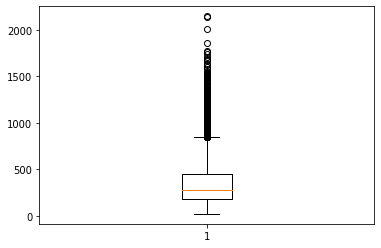

In [ ]:
# Check the distribution of sequence length

# send the tokens to a list and get the length of each list
dfColumnAsList = df['review_tokens'].tolist()
listOfListLengths = [len(i) for i in dfColumnAsList]

print("Mean review length:", np.mean(listOfListLengths))
print("Standard deviation of review length:",np.std(listOfListLengths))

#plot the list of review lengths as a boxplot
fig1, ax1 = plt.subplots()
ax1.boxplot(listOfListLengths)
plt.show()

In [ ]:
# get all of the unique words in the data's vocab

uniqueWordsInData = set(df["review_tokens"].explode().unique())
print("Size of dataset vocab:",len(uniqueWordsInData))
# delete after use
uniqueWordsInData = None

Size of dataset vocab: 222734


In [ ]:
# # Takes ~3 mins, commented out 
# # Print all of the review vocab that is assigned an unknown embedding vector
# uniqueWordsInDataList = df["review_tokens"].explode().unique()
# unknownWords = []
# for i in range(len(uniqueWordsInDataList)):
#   try:
#     model.vocab[uniqueWordsInDataList[i]].index
#   except KeyError:
#     if(uniqueWordsInDataList[i] not in unknownWords):
#       unknownWords.append(uniqueWordsInDataList[i])

In [ ]:
# print("Percentage of unknown tokens:", len(unknownWords) / len(uniqueWordsInDataList))
# print("Unknown tokens:",len(unknownWords))
# print("Example of unknown tokens:",unknownWords[0:50])

Percentage of unknown tokens: 0.30533281851895083
Unknown tokens: 68008
Example of unknown tokens: ["couldn't", "wouldn't", "isn't", "Viera's", "Star's", "Rosie's", "she's", "Debbie's", "Marcia's", "people's", "Meredith's", "Shakespeare's", "Mercutio's", "mother's", 'incomprehendable', '$1800', "won't", 'ANgeles', "Orwell's", "Nicki's", "Bobby's", 'children-Robert', "husband's", "Isn't", "Mullally's", "DOn't", "Grace's", "shouldn't", "haven't", "They're", "show's", 'Bffy', "Live's", "film's", "aren't", "what's", "daughter's", 'Loch-Ness', "Couldn't", 'miscasted', "wasn't", "Andrew's", "Nancy's", "Robert's", "Iola's", "Vint's", "men's", "Drew's", "Ben's", "Parker's"]


In [ ]:
# Check the data split percentage was correct

print("TRAIN PERCENTAGE:      ", train.shape[0]/620, "%")
print("VALIDATION PERCENTAGE: ", validate.shape[0]/620, "%")
print("TEST PERCENTAGE:       ", test.shape[0]/620, "%")


TRAIN PERCENTAGE:       70.0 %
VALIDATION PERCENTAGE:  15.0 %
TEST PERCENTAGE:        15.0 %


In [ ]:
# Check the distribution of samples by author in each set
print(train.groupby('user_id').count().sort_values(by=['review'])['review'])
print(validate.groupby('user_id').count().sort_values(by=['review'])['review'])
print(test.groupby('user_id').count().sort_values(by=['review'])['review'])

# range of values are as we would expect from random sampler

user_id
1219578    665
463200     666
2093818    675
3280905    675
1399158    675
          ... 
3223254    724
453228     725
2488512    726
819382     726
3079504    737
Name: review, Length: 62, dtype: int64
user_id
3079504     125
1532177     130
102816      132
989035      134
15896852    134
           ... 
391152      164
1406078     165
2542703     167
3280905     173
463200      181
Name: review, Length: 62, dtype: int64
user_id
3717154    124
2707735    128
2488512    132
562732     133
3223254    133
          ... 
989035     170
1617546    171
1132073    174
1219578    177
317399     186
Name: review, Length: 62, dtype: int64


ONE TIME PREPROCESSING OF VECTORS, REMOVE VECTORS THAT WILL NOT BE USED AS TOKEN DOES NOT EXIST IN DATA

In [ ]:
# filename = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/glove.840B.300d.txt'
 
# updatedFile = open("drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/reduced-glove.840B.300d.txt", "w")

# uniqueWordsInEmbeddings = set()

# with open(filename) as f:
#   for line in f.readlines():
#     currentVector = line.split()
#     if currentVector[0] in uniqueWordsInData:
#       updatedFile.write(line)
#       uniqueWordsInEmbeddings.add(currentVector[0])

# updatedFile.close()

In [ ]:
# #read in GloVe vectors

# input = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/reduced-glove.840B.300d.txt'
# output = 'drive/MyDrive/NLU Project/data/GloVe300dCommonCrawl/gensim_glove.840B.300d.txt'

In [ ]:
# # convert glpve format into format gensim can read

# gensim.scripts.glove2word2vec.glove2word2vec(input, output)

In [ ]:
# # Load glove vectors into gensim model
# model = gensim.models.KeyedVectors.load_word2vec_format(output, binary=False)

In [ ]:
# # initialize special token representations

# oov_vector = np.random.rand(1, 300)
# model.add([unknownToken],oov_vector)
# pad_vector = np.zeros((1,300))
# model.add([padToken],pad_vector)

In [ ]:
# # Save gensim model
# model.save('drive/MyDrive/NLU Project/data/glove_vectors.kv')

# print(len(uniqueWordsInEmbeddings))
# print(len(uniqueWordsInData))

In [ ]:
# Load gensim model back in
model = gensim.models.KeyedVectors.load('drive/MyDrive/NLU Project/data/preProcessedEmbeddings/glove_vectors.kv')

paddingID = model.vocab[padToken].index

In [ ]:
# get gensim weights and make them pytorch readable
weights = torch.FloatTensor(model.vectors)

In [ ]:
# convert the tokenized sequences to embedding IDs
df["review_tokens_reduced"] = df["review_tokens"]

for index, row in df.iterrows():
  current_list = []
  for token in row['review_tokens']:
    try:
      current_list.append(model.vocab[token].index)
    except KeyError:
      current_list.append(model.vocab[unknownToken].index)
  df.at[index, "review_tokens_reduced"] = current_list


In [ ]:
# show an example of the final data to be placed in dataset
df.head(50)

,user_id,review,user_id_transformed_to_label,review_tokens,review_tokens_reduced
0,33913,Somebody call PETA ! I caught glimpses of this...,38,"[Somebody, call, PETA, !, I, caught, glimpses,...","[13649, 388, 28076, 34, 12, 2324, 31505, 5, 26..."
1,33913,Just Awful ! Mail Rosie a mussel to shut her b...,38,"[Just, Awful, !, Mail, Rosie, a, mussel, to, s...","[487, 35346, 34, 4716, 17737, 6, 55676, 4, 395..."
2,33913,It's not for me ! I just hated it ! After only...,38,"[It's, not, for, me, !, I, just, hated, it, !,...","[139705, 33, 11, 70, 34, 12, 72, 9377, 20, 34,..."
3,33913,"Rosie O'Donnell , Barbara Walters , What has t...",38,"[Rosie, O'Donnell, ,, Barbara, Walters, ,, Wha...","[17737, 23125, 0, 5112, 21355, 0, 182, 42, 26,..."
4,33913,"I thought the Kardashians were bad ! Okay , th...",38,"[I, thought, the, Kardashians, were, bad, !, O...","[12, 386, 2, 49815, 84, 468, 34, 5034, 0, 2, 1..."
5,33913,Why Brokeback Lost the Oscar ? Do you really w...,38,"[Why, Brokeback, Lost, the, Oscar, ?, Do, you,...","[621, 51145, 4265, 2, 7258, 35, 288, 18, 151, ..."
6,33913,Orwell would have been shocked ! I don't get B...,38,"[Orwell, would, have, been, shocked, !, I, don...","[30141, 66, 30, 81, 7878, 34, 12, 128769, 83, ..."
7,33913,The Guide to Parenting Not ! Remember Robert K...,38,"[The, Guide, to, Parenting, Not, !, Remember, ...","[21, 1417, 4, 14466, 437, 34, 2773, 1368, 1587..."
8,33913,Just a Disgrace ! I tried to like Will and Gra...,38,"[Just, a, Disgrace, !, I, tried, to, like, Wil...","[487, 6, 61073, 34, 12, 1031, 4, 61, 1194, 3, ..."
9,33913,"Sorry , this isn't it , Seth ? I love Seth Gre...",38,"[Sorry, ,, this, isn't, it, ,, Seth, ?, I, lov...","[2716, 0, 26, 154745, 20, 0, 11511, 35, 12, 17..."


In [ ]:
# define the dataset 
class IMBDDataset(Dataset):
    """IMDB dataset."""

    # initialize the data in the dataset, pad the sequences to the max length
    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

# pad all of the sequences up to a given length
    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            # if(index % 100 == 0):
            #   print(index)
            paddingNeeded = (lengthToPadTo - len(row['review_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, "review_tokens_reduced"] = row['review_tokens_reduced'] + padData
# convert data that will go to the model into tensors
    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "review_tokens_reduced"] = torch.tensor(row['review_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "user_id_transformed_to_label"] = torch.tensor(row['user_id_transformed_to_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        dfColumnAsList = self.df['review_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)
# on getitem, return the row
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dfRowToReturn = self.df.iloc[idx]
        dictToReturn = {'input': dfRowToReturn['review_tokens_reduced'], 'label': dfRowToReturn['user_id_transformed_to_label']}
        #print(dictToReturn)
        return dictToReturn


In [ ]:
# Split data into train, validate and test sets 70:15:15
np.random.seed(seed=6)
train, validate, test = np.split(df.sample(frac=1, random_state=6), 
                        [int(.7*len(df)), int(.85*len(df))])
# verify and show example
print("TRAIN PERCENTAGE:      ", train.shape[0]/620, "%")
print("VALIDATION PERCENTAGE: ", validate.shape[0]/620, "%")
print("TEST PERCENTAGE:       ", test.shape[0]/620, "%")

train.head()

TRAIN PERCENTAGE:       70.0 %
VALIDATION PERCENTAGE:  15.0 %
TEST PERCENTAGE:        15.0 %


,user_id,review,user_id_transformed_to_label,review_tokens,review_tokens_reduced
5756,342623,Not an easy film - neither was the Cold War Ri...,39,"[Not, an, easy, film, -, neither, was, the, Co...","[437, 37, 410, 647, 16, 3676, 29, 2, 5497, 126..."
3597,306861,Just The Facts From Disney A Walt Disney THE H...,32,"[Just, The, Facts, From, Disney, A, Walt, Disn...","[487, 21, 7354, 369, 3178, 76, 10287, 3178, 41..."
33679,1617546,The Story of Ruth Ruth Etting was a Broadway s...,18,"[The, Story, of, Ruth, Ruth, Etting, was, a, B...","[21, 2485, 5, 8586, 8586, 108084, 29, 6, 6151,..."
11236,463200,Sure it's sexist but fun in a non-think sort o...,49,"[Sure, it's, sexist, but, fun, in, a, non-thin...","[4673, 131336, 27463, 39, 471, 7, 6, 154745, 1..."
42528,2567136,The Two Faces Of Lulu Carine Tardieu has turne...,27,"[The, Two, Faces, Of, Lulu, Carine, Tardieu, h...","[21, 1025, 14398, 312, 25609, 72103, 121680, 4..."


In [ ]:
train_dataset = IMBDDataset(train)
validate_dataset = IMBDDataset(validate)
test_dataset = IMBDDataset(test)

In [ ]:
train_dataset.getMaximumLengthSequence()

2147

In [ ]:
# save the datasets

torch.save(test_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtest.pt')
torch.save(train_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtrain.pt')
torch.save(validate_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBvalidate.pt')

In [ ]:
# Siamese Dataset Definition

class IMBDSiameseDataset(Dataset):
    """IMDB dataset for siamese implementation."""

    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            # if(index % 100 == 0):
            #   print(index)
            paddingNeeded = (lengthToPadTo - len(row['review_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, "review_tokens_reduced"] = row['review_tokens_reduced'] + padData

    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "review_tokens_reduced"] = torch.tensor(row['review_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "user_id_transformed_to_label"] = torch.tensor(row['user_id_transformed_to_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        dfColumnAsList = self.df['review_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input1 = self.df.sample()

        should_get_same_class = np.random.randint(0,2) 
        if should_get_same_class:
            while True:
                input2 = self.df.sample()
                if input1['user_id_transformed_to_label'].iloc[0] == input2['user_id_transformed_to_label'].iloc[0]:
                    break
        else:

            while True:
                input2 = self.df.sample()
                if input1['user_id_transformed_to_label'].iloc[0] != input2['user_id_transformed_to_label'].iloc[0]:
                    break


        dictToReturn = {'input1': input1['review_tokens_reduced'].iloc[0], 'label1': input1['user_id_transformed_to_label'].iloc[0], 
                        'input2': input2['review_tokens_reduced'].iloc[0], 'label2': input2['user_id_transformed_to_label'].iloc[0], 
                        'same_class' : int(input1['user_id_transformed_to_label'].iloc[0] == input2['user_id_transformed_to_label'].iloc[0])}
        return dictToReturn

In [ ]:
#repeat the same saving, but for the siamese dataset
siamese_train_dataset = IMBDSiameseDataset(train)
siamese_validate_dataset = IMBDSiameseDataset(validate)
siamese_test_dataset = IMBDSiameseDataset(test)
torch.save(siamese_test_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtestSiamese.pt')
torch.save(siamese_train_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtrainSiamese.pt')
torch.save(siamese_validate_dataset, 'drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBvalidateSiamese.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
